# Exploratory Analysis
---

## 1. Imports

In [272]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import json
from wordcloud import WordCloud
from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

## 2. Load Dataset

In [273]:
email_df = pd.read_parquet("./data/2_clean_email_dataset.parquet")
email_df

,Email Text,Email Type
1,gary production high island larger block comme...,ham
2,calpine daily gas nomination doc,ham
3,fyi see note already done stella forwarded ste...,ham
4,fyi forwarded lauri allen hou ect pm kimberly ...,ham
5,jackie since inlet river plant shut last day f...,ham
...,...,...
52360,rick moen im confused thought gpled money paid...,ham
52361,date lonely housewife always wanted date lonel...,phish
52362,request submitted access request anita dupont ...,ham
52363,important prc mtg hi dorn john discovered rece...,ham


## 3. Statistics
Get ham, spam, and phish row count after cleanup.

In [274]:
email_df["Email Type"].value_counts()

Email Type
ham      27617
spam     17171
phish     6977
Name: count, dtype: int64

Most data is legitimate (ham), so the model may overfit to it. Sampling balance is needed

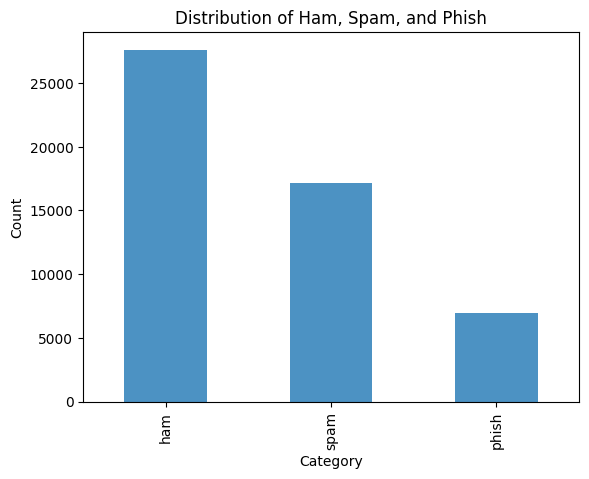

In [275]:
email_df["Email Type"].value_counts().plot(kind='bar', alpha=0.8)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

We must undersample `ham` and oversample `phish` up to the median of the classes, that being the count of spam emails.

In [276]:
balanced_df = email_df.copy()

# Get class counts
class_counts = balanced_df['Email Type'].value_counts()
print(class_counts)

# Define target count for majority class after undersampling
# For example, take the median count to not reduce too much
target_majority_count = int(class_counts.median())

# Separate by class
dfs = {}
for cls in balanced_df['Email Type'].unique():
    dfs[cls] = balanced_df[balanced_df['Email Type'] == cls]

# Undersample majority class
majority_class = class_counts.idxmax()
dfs[majority_class] = resample(
    dfs[majority_class],
    replace=False,
    n_samples=target_majority_count,
    random_state=42
)

# Oversample minority classes to reach target_majority_count
for cls, df in dfs.items():
    if cls != majority_class:
        dfs[cls] = resample(
            df,
            replace=True,
            n_samples=target_majority_count,
            random_state=42
        )

# Combine back into a single dataframe
balanced_df = pd.concat(list(dfs.values()))

# Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
balanced_df['Email Type'].value_counts()


Email Type
ham      27617
spam     17171
phish     6977
Name: count, dtype: int64


Email Type
ham      17171
phish    17171
spam     17171
Name: count, dtype: int64

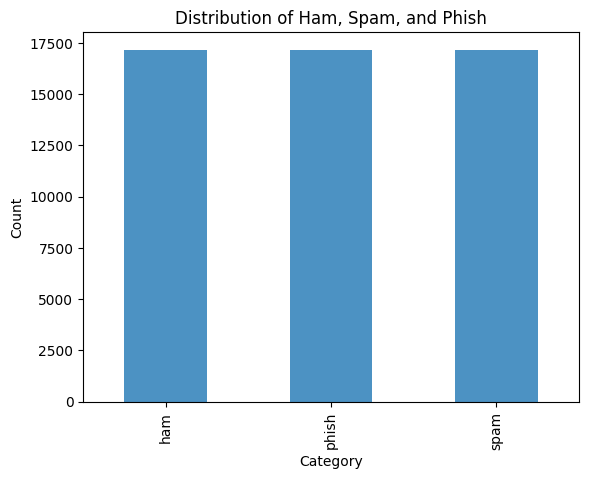

In [277]:
balanced_df["Email Type"].value_counts().plot(kind='bar', alpha=0.8)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

Export as balanced dataframe to a CSV file for later use with the SVM model.

In [278]:
balanced_df.to_parquet("./data/2_balanced_email_dataset.parquet")

### Text Characteristics
Get the text characteristics before the data was cleaned via the column `"Email Text"`.

In [279]:
# Text length metrics
balanced_df["char_count"] = balanced_df["Email Text"].str.len()
balanced_df["word_count"] = balanced_df["Email Text"].apply(word_tokenize).apply(len)
balanced_df["sentence_count"] = balanced_df["Email Text"].apply(sent_tokenize).apply(len)

# # Count URLs
url_pattern = r"http[s]?://\S+|www\.\S+"
balanced_df["url_count"] = balanced_df["Email Text"].apply(lambda x: len(re.findall(url_pattern, x)))

# Count special characters
balanced_df["special_chars"] = balanced_df["Email Text"].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

In [280]:
balanced_df[["char_count", "word_count", "sentence_count"]].describe()

,char_count,word_count,sentence_count
count,5.151300e+04,5.151300e+04,51513.000000
mean,1.247289e+03,1.769762e+02,0.999534
std,4.731010e+04,6.336897e+03,0.021580
min,0.000000e+00,0.000000e+00,0.000000
25%,3.450000e+02,5.100000e+01,1.000000
50%,5.110000e+02,7.500000e+01,1.000000
75%,1.011000e+03,1.430000e+02,1.000000
max,1.072574e+07,1.436505e+06,1.000000


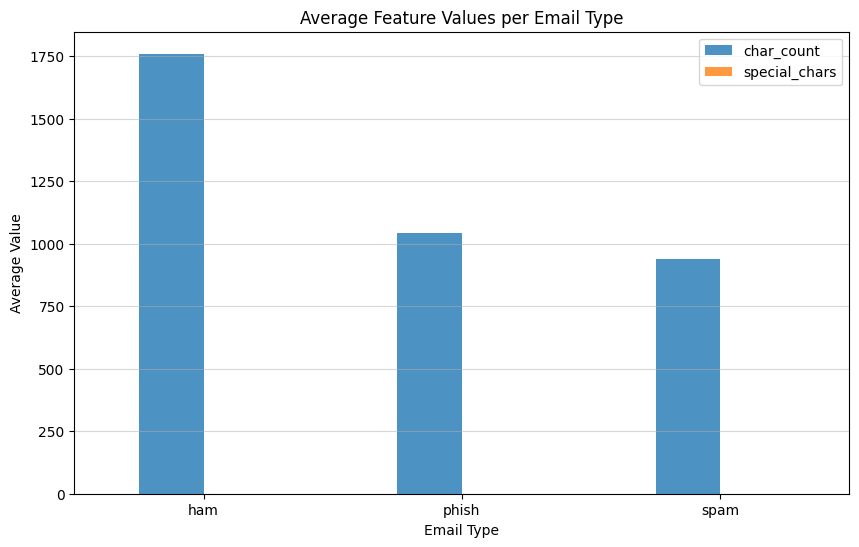

In [281]:
feature_cols = ["char_count", "special_chars"]
grouped = balanced_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Average Feature Values per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

Sentence count between ham, phish, and spam.

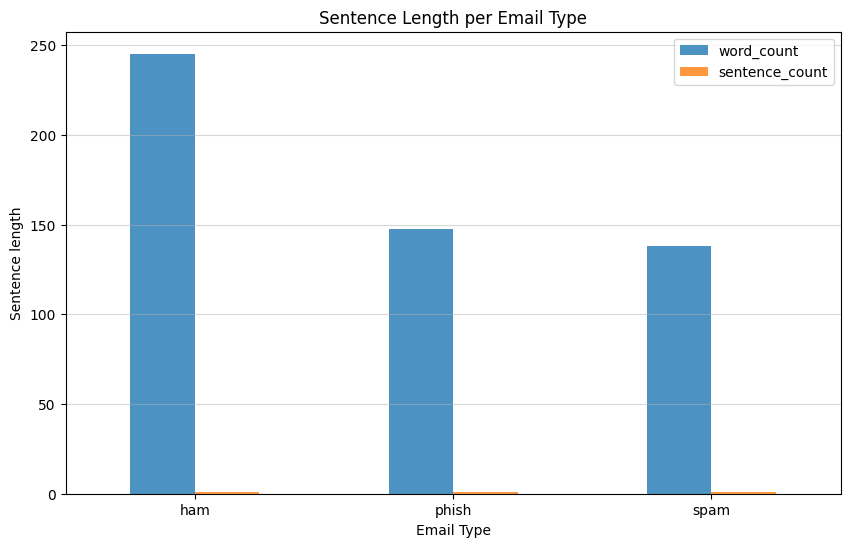

In [282]:
feature_cols = ["word_count", "sentence_count"]
grouped = balanced_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Sentence Length per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Sentence length")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

In [284]:
stop_words = set(stopwords.words("english"))

def get_top_words_clean(texts, n=20):
    """Return top n most common words."""
    all_words = []
    for txt in texts:
        all_words.extend(txt.split()) 
    return Counter(all_words).most_common(n)

Initialize `top_words` and populate with top words if not already populated (process takes some time when initialized).

In [287]:
categories = balanced_df["Email Type"].unique().tolist()
top_words_clean = dict()

if Path("./data/3_top_words.json").exists():
    with open("./data/3_top_words.json", 'r') as file:
        top_words_clean = json.load(file)

if top_words_clean.keys().isdisjoint(categories):
    for category in categories:
        words = get_top_words_clean(balanced_df[balanced_df["Email Type"] == category]["Email Text"])
        top_words_clean[category] = words

    with open("./data/3_top_words.json", 'w') as file:
        json.dump(top_words_clean, file, indent=4)

In [288]:
pd.DataFrame(top_words_clean).head()

,ham,phish,spam
0,"(enron, 48292)","(â, 18809)","(e, 45165)"
1,"(ect, 28061)","(email, 17565)","(enron, 45040)"
2,"(language, 20573)","(company, 12514)","(ubs, 41552)"
3,"(would, 15971)","(u, 11215)","(message, 34402)"
4,"(please, 15795)","(free, 10835)","(please, 28258)"


Some words do not appear to provide any additional value, like `enron` which is where the ham & spam emails are from. Let's remove them.

In [289]:
# def remove_words(text, words_to_remove: list[str]):
#     """Uses re.sub() to replace all occurrences of words to remove."""
#     regex_pattern = r'\b(?:' + '|'.join(words_to_remove) + r')\b'
#     return re.sub(regex_pattern, '', str(text), flags=re.IGNORECASE)

# balanced_df["Email Text"] = balanced_df["Email Text"].apply(
#     lambda x: remove_words(x, ["enron", "ubs", "etc", "ect", "e"])
# )

# for category in categories:
#         words = get_top_words_clean(balanced_df[balanced_df["Email Type"] == category]["Email Text"])
#         top_words_clean[category] = words

# with open("./data/3_top_words.json", 'w') as file:
#     json.dump(top_words_clean, file, indent=4)

# pd.DataFrame(top_words_clean).head()

Use `get_top_words_clean` function to plot the most common words for each category.

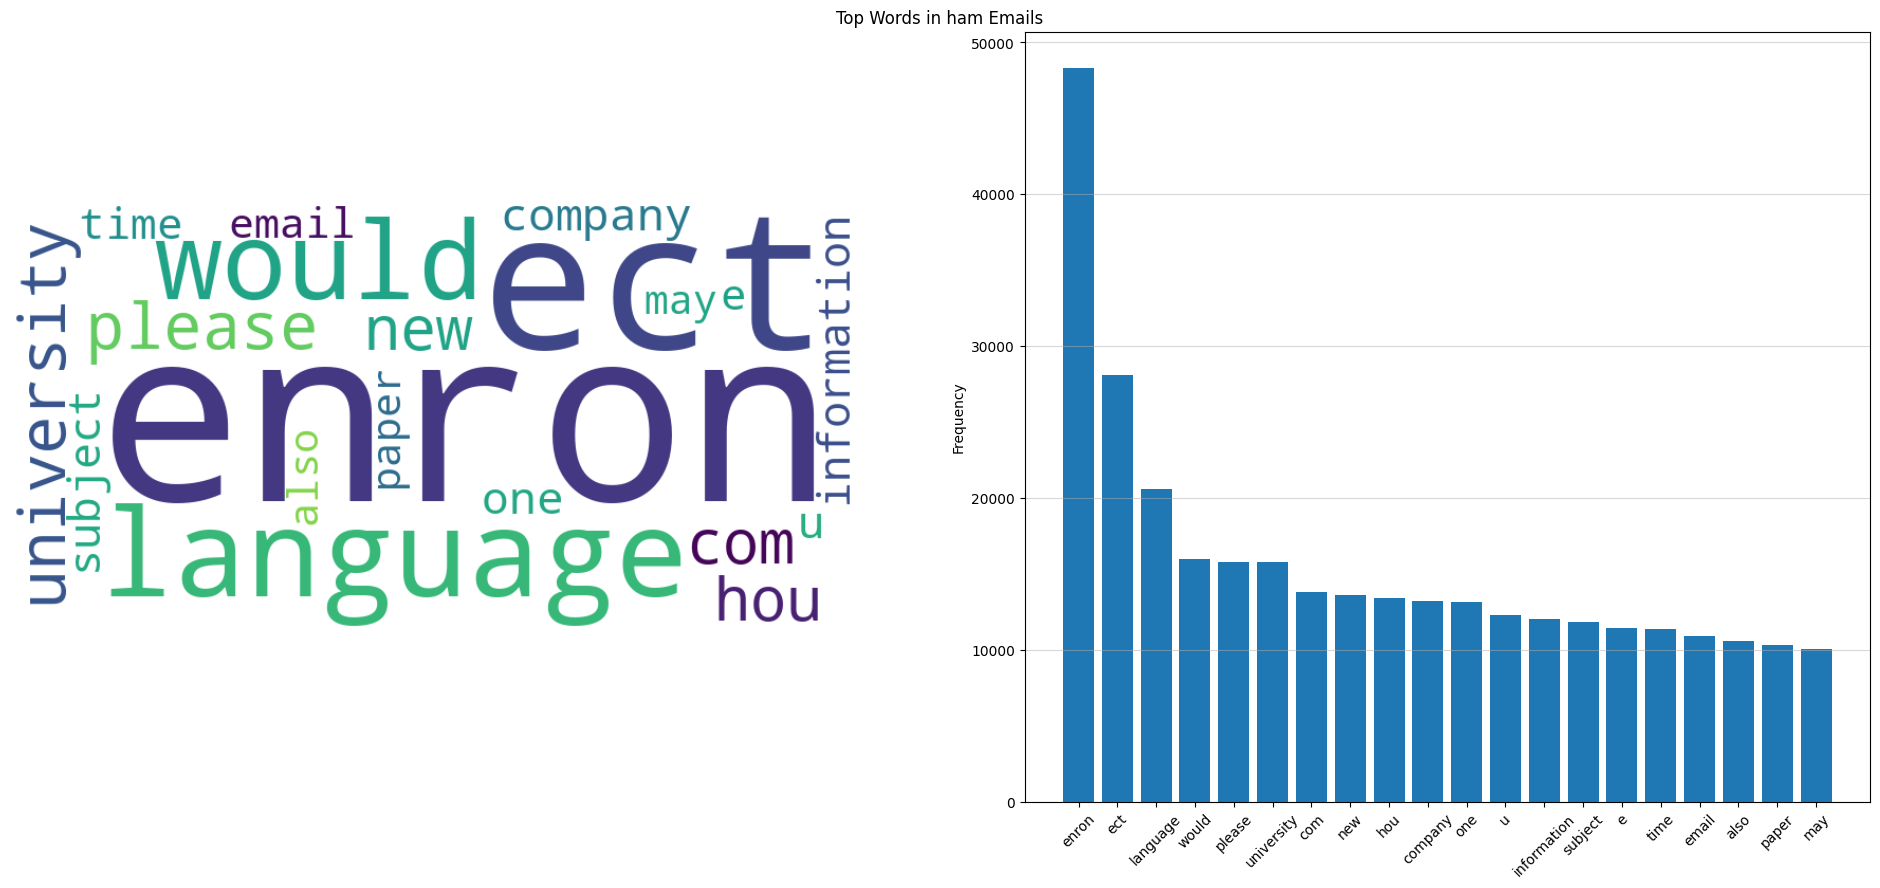

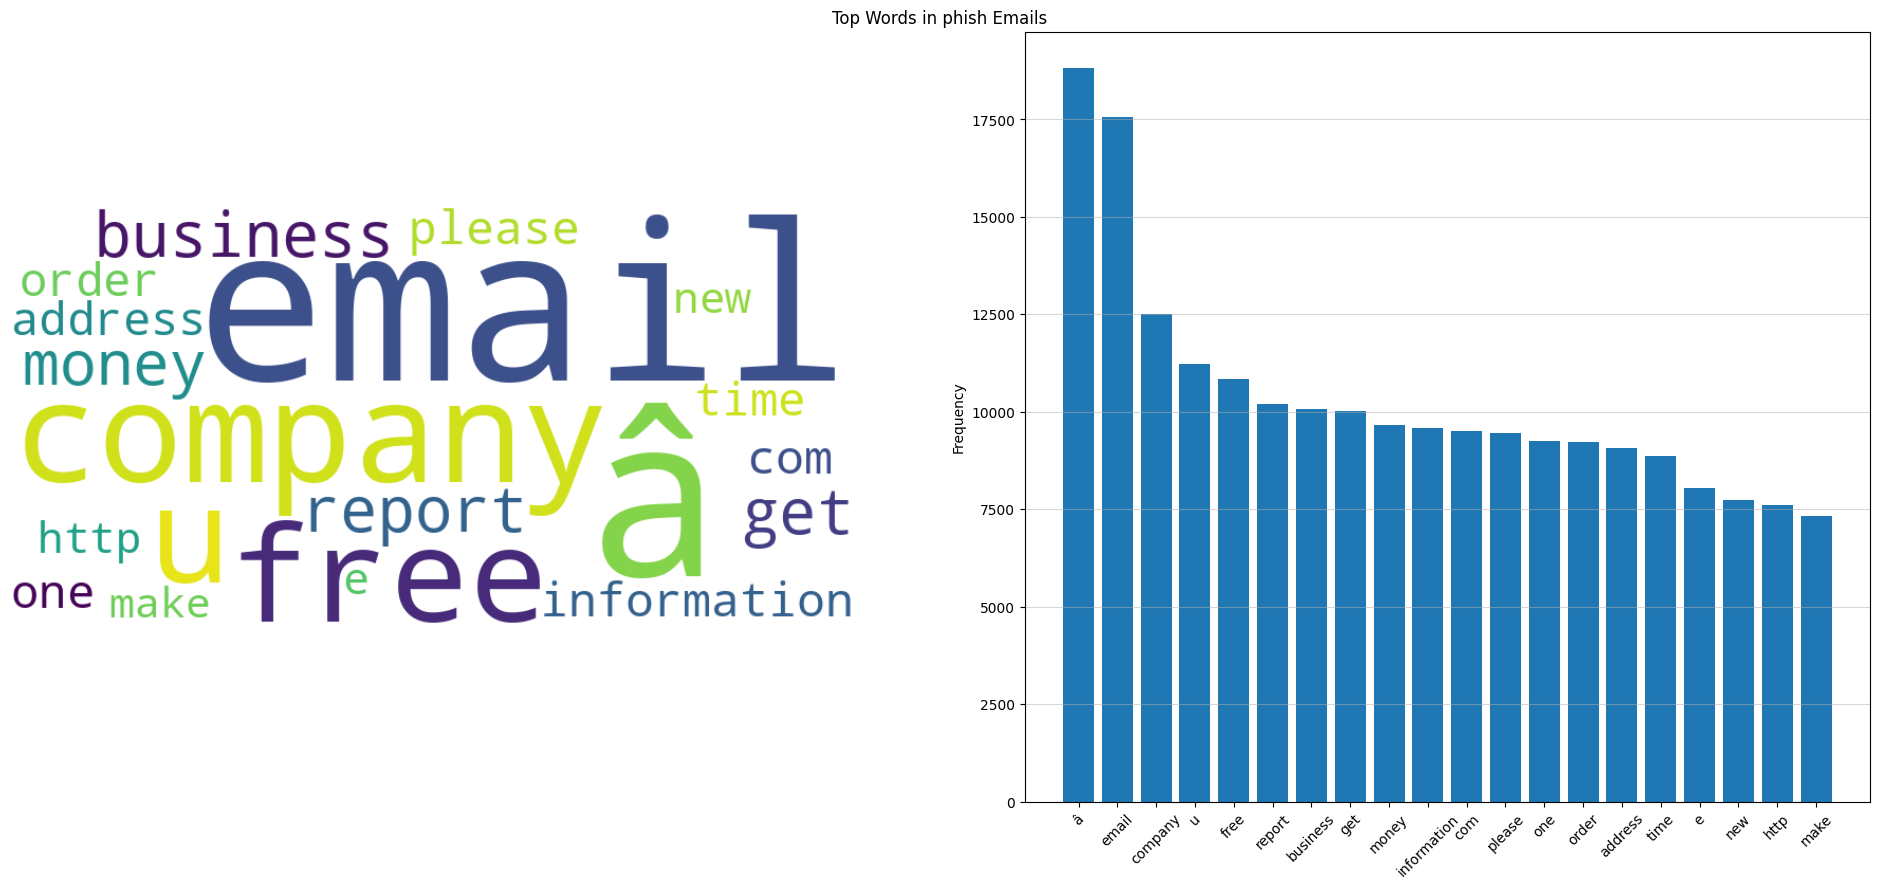

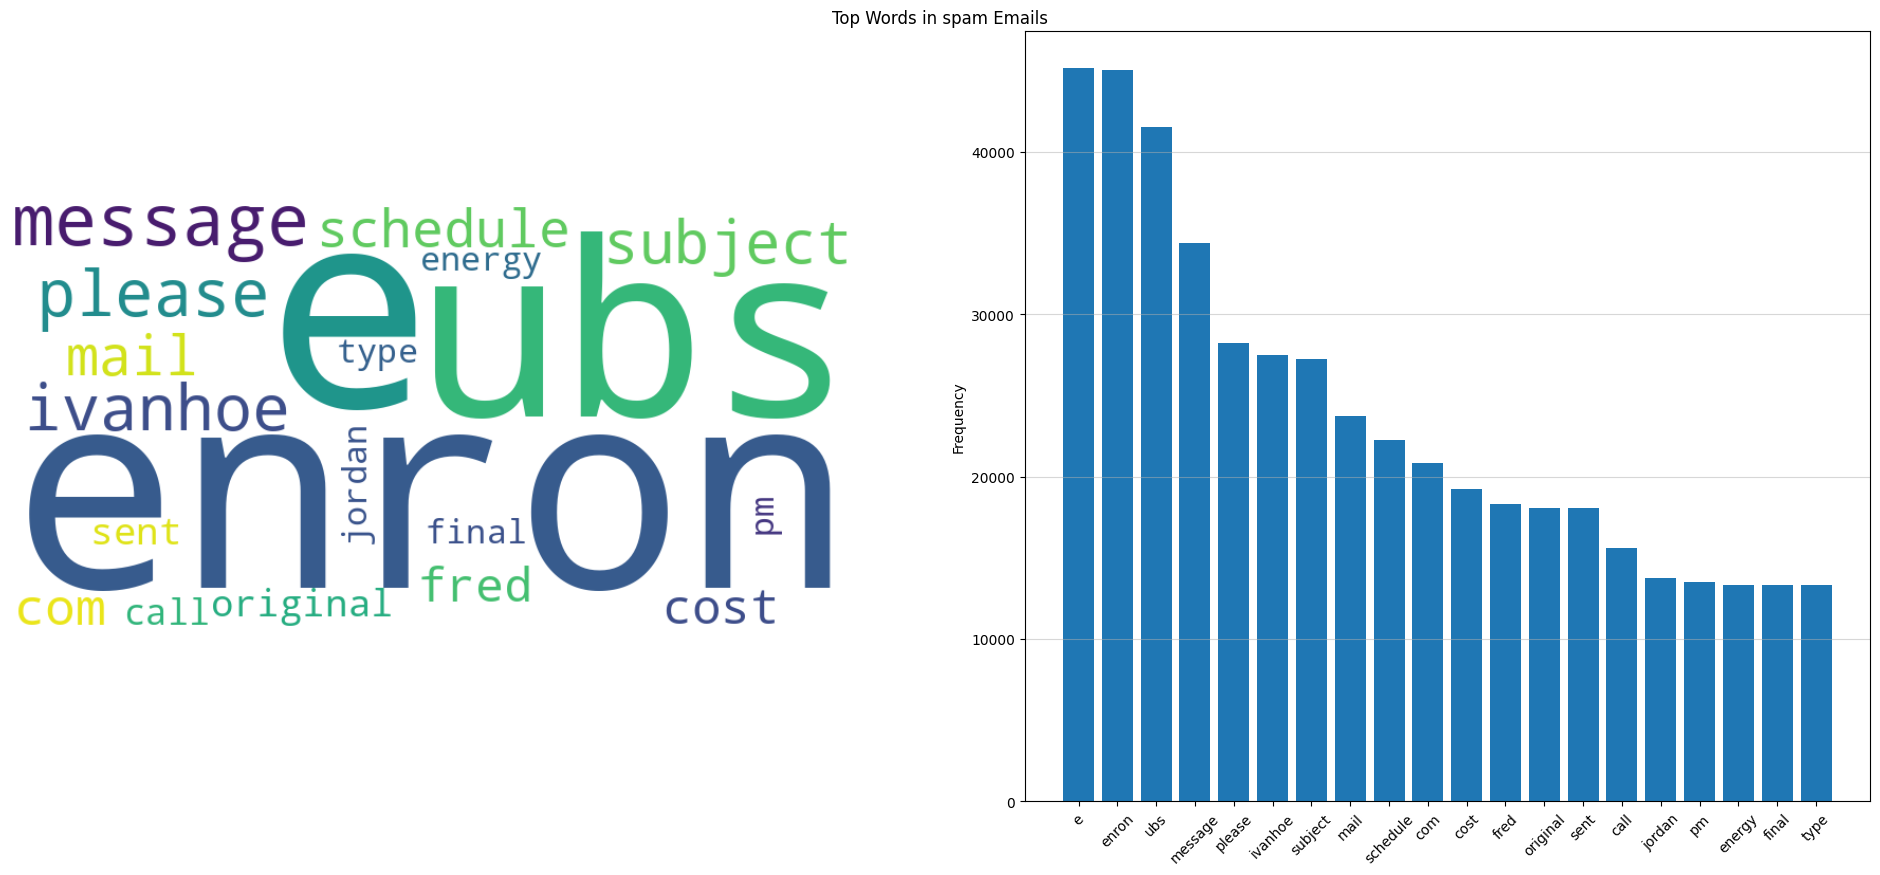

In [290]:
for category in categories:
    words, counts = zip(*top_words_clean[category])

    plt.figure(figsize=(24, 10), alpha=0.8)
    plt.title(f"Top Words in {category} Emails")
    plt.axis('off')

    wordcloud = WordCloud(
        width=800, height=400, background_color='white'
    ).generate_from_frequencies(dict(top_words_clean[category]))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.5)
    plt.show()